### Alistamento militar - Aprendizado de Máquina

Neste notebook é executado o treino dos classificadores Decision Tree e Random Forest. A análise gráfica pode ser encontrada em outro notebook no [github do projeto](https://github.com/rafaelgard/Data-Science-Aplicado-ao-Alistamento-Militar)

In [1]:
#Faz a ligação com o banco de dados do Google
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib

In [3]:
%%time
#Importando o dataframe inicial atualizado

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Alistamento Militar/df_atualizado_utf8.csv",sep=",",encoding='UTF-8')

CPU times: user 29 s, sys: 5.42 s, total: 34.4 s
Wall time: 48.8 s


In [4]:
# Define a coluna indice como índice da tabela, permitindo assim a realização da busca usando a função df.loc
df=df.set_index('ÍNDICE')


In [5]:
df.head()

,ANO_NASCIMENTO,PAIS_NASCIMENTO,ESTADO_CIVIL,ESCOLARIDADE,VINCULACAO_ANO,DISPENSA,ZONA_RESIDENCIAL,MUN_RESIDENCIA,UF_RESIDENCIA,PAIS_RESIDENCIA,IDADE
ÍNDICE,,,,,,,,,,,
0,1989,BRASIL,Solteiro,Ensino Médio Completo,2007,Sem dispensa,Urbana,PIRASSUNUNGA,SP,BRASIL,18
1,1989,BRASIL,Casado,Ensino Superior Completo,2007,Sem dispensa,Urbana,SAO PAULO,SP,BRASIL,18
2,1989,BRASIL,Solteiro,Ensino Médio Completo,2007,Sem dispensa,Urbana,CATANDUVA,SP,BRASIL,18
3,1989,BRASIL,Solteiro,Ensino Médio Completo,2007,Sem dispensa,Urbana,PIRAJUI,SP,BRASIL,18
4,1989,BRASIL,Solteiro,Ensino Médio Completo,2007,Sem dispensa,Urbana,PIRAJUI,SP,BRASIL,18


# Analisando os dados

In [6]:
#Verificando a existencia de dados nulos
print("Dados nulos:")
print(df.isnull().sum())

Dados nulos:
ANO_NASCIMENTO      0
PAIS_NASCIMENTO     0
ESTADO_CIVIL        0
ESCOLARIDADE        0
VINCULACAO_ANO      0
DISPENSA            0
ZONA_RESIDENCIAL    0
MUN_RESIDENCIA      0
UF_RESIDENCIA       0
PAIS_RESIDENCIA     0
IDADE               0
dtype: int64


In [7]:
print('Informações sobre o dataframe')
print(df.info())

Informações sobre o dataframe
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21365330 entries, 0 to 21365329
Data columns (total 11 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   ANO_NASCIMENTO    int64 
 1   PAIS_NASCIMENTO   object
 2   ESTADO_CIVIL      object
 3   ESCOLARIDADE      object
 4   VINCULACAO_ANO    int64 
 5   DISPENSA          object
 6   ZONA_RESIDENCIAL  object
 7   MUN_RESIDENCIA    object
 8   UF_RESIDENCIA     object
 9   PAIS_RESIDENCIA   object
 10  IDADE             int64 
dtypes: int64(3), object(8)
memory usage: 1.9+ GB
None


### Analisandos os dados únicos em cada coluna

In [8]:
print('=================================================')
for coluna in df.columns:
  print('Coluna: ', coluna)
  print(np.unique(df[coluna], return_counts = True)[0])
  print('=================================================')

Coluna:  ANO_NASCIMENTO
[1900 1908 1911 1919 1920 1921 1922 1924 1925 1926 1927 1928 1929 1930
 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944
 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958
 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986
 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2018]
Coluna:  PAIS_NASCIMENTO
['ADÉLIA' 'AFEGANISTÃO' 'AFRICA DO SUL' 'ALASCA' 'ALBÂNIA' 'ALEMANHA'
 'ANDORRA' 'ANGOLA' 'ANGUILLA' 'ANTÁRTICA' 'ANTÍGUA E BARBUDA' 'ARGENTINA'
 'ARGÉLIA' 'ARMÊNIA' 'ARUBA' 'ARÁBIA SAUDITA' 'AUSTRÁLIA' 'AZERBAIJÃO'
 'AÇORES' 'BAHAMAS' 'BAHREIN' 'BANGLADESH' 'BARBADOS' 'BELARUS' 'BELIZE'
 'BENIN' 'BERMUDAS' 'BIRMÂNIA' 'BOLÍVIA' 'BOTSUANA' 'BRASIL'
 'BRUNEI E DAR ES-SALAAM' 'BULGÁRIA' 'BURKINA FASSO' 'BURUNDI' 'BUTÃO'
 'BÉLGICA' 'BÓSNIA E HERZEGOVINA' 'CABO VERDE' 'CAMARÕES' 'CAMBOJA'
 'CANADÁ' 'CAS

## Tratando os dados

### Tratando os valores das colunas de município de residência e UF de residência

In [9]:
#Devido a existencia de cidades com o mesmo nome em estados diferentes, 
#se faz necessário cria uma coluna que identifique as cidades individualmente
df['CIDADE-ESTADO']=df['MUN_RESIDENCIA']+'-'+df['UF_RESIDENCIA']
df = df.drop(['MUN_RESIDENCIA','UF_RESIDENCIA'], axis=1)

### Filtrando os valores da coluna ano de nascimento

In [10]:
#Adequa o ano de nascimento para considerar apenas pessoas que podem de fato servir
df=df[df['ANO_NASCIMENTO']>=1962]
df=df[df['ANO_NASCIMENTO']<=1989]

### Filtrando os valores da coluna idade

In [11]:
#Adequa a idade para ficar entre 18 e 45 anos já que apenas nesta faixa de idade é possível se alistar
df=df[df['IDADE']>=18]
df=df[df['IDADE']<=45]

### Tratando os valores da coluna dispensa

In [12]:
#Verificando as colunas da coluna dispensa, podemos ver que temos valores 'Não informado' o que prejudica a análise.
#Esse caso será tratado a seguir
df['DISPENSA'].unique()

array(['Sem dispensa', 'Com dispensa', 'Não informado'], dtype=object)

In [13]:
def dispensa(status):
  if status == 'Não informado':
    return 2

  if status == 'Sem dispensa':
    return 1

  if status == 'Com dispensa':
    return 0

#Padronizando a coluna dispensa
df['DISPENSA']=df['DISPENSA'].apply(lambda x: dispensa(x))

#Os dados da coluna dispensa com valor 'Não informado' são dropados
df=df[df['DISPENSA']!= 2]

In [14]:
#A coluna 'DISPENSA' é o target, logo deve ser eliminada do dataframe principal
target = df["DISPENSA"]
df = df.drop(['DISPENSA'], axis=1)

### Tratando os valores da coluna estado cívil

In [15]:
### Os termos 'Desquitado' e 'Separado Judicialmente', serão substituidos por 'divorciado'
df['ESTADO_CIVIL']=df['ESTADO_CIVIL'].replace('Desquitado', 'Divorciado')
df['ESTADO_CIVIL']=df['ESTADO_CIVIL'].replace('Separado Judicialmente', 'Divorciado')
df['ESTADO_CIVIL']=df['ESTADO_CIVIL'].replace('Viuvo', 'Viúvo')

In [16]:
df.head()

,ANO_NASCIMENTO,PAIS_NASCIMENTO,ESTADO_CIVIL,ESCOLARIDADE,VINCULACAO_ANO,ZONA_RESIDENCIAL,PAIS_RESIDENCIA,IDADE,CIDADE-ESTADO
ÍNDICE,,,,,,,,,
0,1989,BRASIL,Solteiro,Ensino Médio Completo,2007,Urbana,BRASIL,18,PIRASSUNUNGA-SP
1,1989,BRASIL,Casado,Ensino Superior Completo,2007,Urbana,BRASIL,18,SAO PAULO-SP
2,1989,BRASIL,Solteiro,Ensino Médio Completo,2007,Urbana,BRASIL,18,CATANDUVA-SP
3,1989,BRASIL,Solteiro,Ensino Médio Completo,2007,Urbana,BRASIL,18,PIRAJUI-SP
4,1989,BRASIL,Solteiro,Ensino Médio Completo,2007,Urbana,BRASIL,18,PIRAJUI-SP


## Categorização dos dados

In [17]:
for col in ['CIDADE-ESTADO','PAIS_RESIDENCIA','ANO_NASCIMENTO','PAIS_NASCIMENTO','VINCULACAO_ANO','IDADE']:
    # Converte a coluna para 'category'
    df[col] = df[col].astype('category')
    # Cria uma nova coluna codificada
    df[col+'_new']=df[col].cat.codes
    # Elimina a coluna original
    df.drop(col, axis=1, inplace=True)
for col in ['ZONA_RESIDENCIAL','ESTADO_CIVIL','ESCOLARIDADE']:
    nova_col = pd.get_dummies(df[col])
    df = pd.concat([df,nova_col],axis=1)
    df.drop(col, axis=1,inplace=True)

In [18]:
df.head()

,CIDADE-ESTADO_new,PAIS_RESIDENCIA_new,ANO_NASCIMENTO_new,PAIS_NASCIMENTO_new,VINCULACAO_ANO_new,IDADE_new,Rural,Urbana,Casado,Divorciado,Outros,Solteiro,Viúvo,Alfabetizado,Analfabeto,Doutorado,Ensino Fundamental Completo,Ensino Fundamental Incompleto,Ensino Médio Completo,Ensino Médio Incompleto,Ensino Superior Completo,Ensino Superior Incompleto,Mestrado,Pós-Doutorado,Pós-Graduação
ÍNDICE,,,,,,,,,,,,,,,,,,,,,,,,,
0,3894,26,27,24,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,4914,26,27,24,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1188,26,27,24,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,3878,26,27,24,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3878,26,27,24,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


# Algoritmo de classificação

## Importa funções e modelos

In [19]:
def decision_tree_classificador(train_X:pd.core.frame.DataFrame, test_X:pd.core.frame.DataFrame, train_y:pd.core.series.Series, test_y:pd.core.series.Series):
    #Importando as bibliotecas
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import accuracy_score
    
    # Decision Tree
    #Define os parametros do modelo
    decision_tree = DecisionTreeClassifier(min_samples_split= 4, min_samples_leaf= 3, max_depth= 19, criterion= 'entropy')
    
    #Treina o modelo
    decision_tree.fit(train_X, train_y)
    
    #Calcula o score do modelo
    acc_decision_tree = round(decision_tree.score(test_X, test_y) * 100, 2)
    
    return decision_tree, acc_decision_tree #Retorna o modelo e o score do modelo

In [20]:
def random_forest_classificador(train_X:pd.core.frame.DataFrame, test_X:pd.core.frame.DataFrame, train_y:pd.core.series.Series, test_y:pd.core.series.Series):
    #Importando as bibliotecas
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    
    # Random Forest
    #Define os parametros do modelo
    random_forest = RandomForestClassifier(n_estimators=20, max_depth=40, n_jobs=-1)

    #Treina o modelo
    random_forest.fit(train_X, train_y)
    
    #Calcula o score do modelo
    acc_random_forest = round(random_forest.score(test_X, test_y) * 100, 2)
    
    return random_forest, acc_random_forest #Retorna o modelo e o score do modelo

In [21]:
def avalia_classificador(clf, x_test, y_test):
  #Esta função avalia os classificadores
  from sklearn.metrics import precision_recall_fscore_support
  from sklearn.metrics import confusion_matrix,accuracy_score
  predictions = clf.predict(x_test)
  print('Relatório de precisão:\nprecision \t\t\t recall \t\t\t f-score \t\t\t support\n',
        precision_recall_fscore_support(y_test, predictions)[0],'\t',
        precision_recall_fscore_support(y_test, predictions)[1],
        '\t',precision_recall_fscore_support(y_test, predictions)[2],'\t',
        precision_recall_fscore_support(y_test, predictions)[3],'\n')
  print('Matriz de confusão:\n',confusion_matrix(y_test, predictions),'\n')
  print('Accuracy score:',accuracy_score(y_test, predictions)*100,'\n')

def melhores_features(modelo, train_X):
  #Extrai a importância de cada característica (feature)
  analise = pd.DataFrame({'Característica': list(train_X.columns),
                    'importancia': modelo.feature_importances_}).\
                      sort_values('importancia', ascending = False)
                      
  return(analise)

def curva_roc(clf, x_test, y_test):
  import matplotlib.pyplot as plt
  from sklearn.metrics import plot_roc_curve
  plot_roc_curve(clf, x_test, y_test)
  plt.show()

In [22]:
def gerador_de_dados_de_treino_e_teste(dataframe, target, ajustar_escala):
  # Gera os dados de treino e teste com escala já ajustada
  from sklearn.model_selection import train_test_split
  x_train, x_test, y_train, y_test = train_test_split(dataframe, target, test_size=0.3, random_state=30, stratify=target)
  
  # Se for escolhido ajustar escala, as escalas dos dados de treino e teste são ajustadas
  if ajustar_escala == True:
    x_train, x_test = ajustador_de_escala(x_train, x_test)

  return (x_train, x_test, y_train, y_test)

def ajustador_de_escala(x_train, x_test):
  #Ajusta a escala dos dados removendo outlyers e melhorando a acurácia do modelo
  from sklearn.neural_network import MLPClassifier
  from sklearn.preprocessing import RobustScaler
  
  #Ajusta as features
  scaler = RobustScaler()
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)  
  x_test = scaler.transform(x_test)

  return (x_train, x_test)

def und_sampling(train_X:pd.core.frame.DataFrame,train_y:pd.core.series.Series):
#Gera os conjuntos de treino e teste balanceados por undersampling
    #Importando as bibliotecas
    from imblearn.under_sampling import RandomUnderSampler
    import seaborn as sns
    
    # Aplicando a técnica undersampling
    rus = RandomUnderSampler()

    #Novos conjuntos de treino gerados
    X_und, y_und = rus.fit_sample(train_X, train_y)

    # Verificar o balanceamento das classes
    print(pd.Series(y_und).value_counts())

    # Plotar a nova distribuição de classes
    sns.countplot(y_und)
    
    #Retorna os novos conjuntos de treino gerados
    return X_und, y_und

## Gera conjuntos de treino e teste

In [23]:
# Salva o nome das colunas
colunas=df.columns

# Cria os dados de treino e teste
train_X, test_X, train_y, test_y = gerador_de_dados_de_treino_e_teste(df, target, False)

# Libera memória ram
df=pd.DataFrame()
target=[]

# Treina classificadores

### Treinando o classificador 1: Decision Tree

In [24]:
clf, acc_decision_tree=decision_tree_classificador(train_X, test_X, train_y, test_y)

In [25]:
print('clf',type(clf))
print('acc_decision_tree',type(acc_decision_tree))

clf <class 'sklearn.tree._classes.DecisionTreeClassifier'>
acc_decision_tree <class 'numpy.float64'>


### Avaliando o classificador 1

Relatório de precisão:
precision 			 recall 			 f-score 			 support
 [0.92025385 0.73357031] 	 [0.95455246 0.6020299 ] 	 [0.93708942 0.66132254] 	 [1070355  222474] 

Matriz de confusão:
 [[1021710   48645]
 [  88538  133936]] 

Accuracy score: 89.38892923967516 



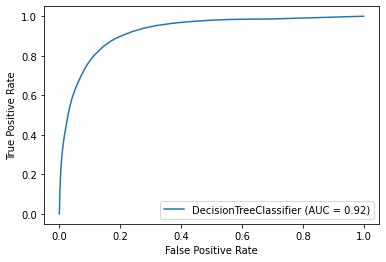

In [26]:
avalia_classificador(clf, test_X, test_y)
curva_roc(clf, test_X, test_y)

As caracteristicas mais importantes do modelo são:
                   Característica  importancia
0               CIDADE-ESTADO_new     0.459062
5                       IDADE_new     0.402563
7                          Urbana     0.036473
13                   Alfabetizado     0.030317
4              VINCULACAO_ANO_new     0.015440
18          Ensino Médio Completo     0.010140
17  Ensino Fundamental Incompleto     0.010027
6                           Rural     0.008750
2              ANO_NASCIMENTO_new     0.005920
16    Ensino Fundamental Completo     0.004169
20       Ensino Superior Completo     0.003691
21     Ensino Superior Incompleto     0.003588
11                       Solteiro     0.002672
19        Ensino Médio Incompleto     0.002214
14                     Analfabeto     0.001328
8                          Casado     0.000993
10                         Outros     0.000771
1             PAIS_RESIDENCIA_new     0.000732
24                  Pós-Graduação     0.000419
9        

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

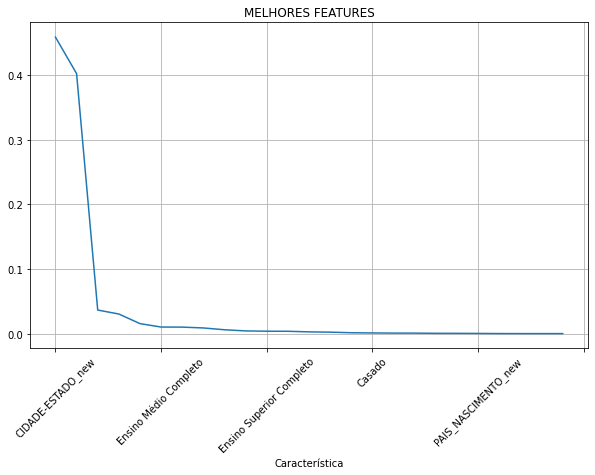

In [27]:
analise=melhores_features(clf, train_X)

# Imprime as caracteristicas mais importantes do modelo
print("As caracteristicas mais importantes do modelo são:")
print(analise)
analise.plot('Característica', 'importancia', figsize=(10,6), legend=False, title ='MELHORES FEATURES', grid =1)
plt.xticks(rotation=45)

## Treinando os classificadores com undersampling

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



1    519105
0    519105
dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Relatório de precisão:
precision 			 recall 			 f-score 			 support
 [0.96827207 0.51798663] 	 [0.83195202 0.8688431 ] 	 [0.8949507  0.64903297] 	 [1070355  222474] 

Matriz de confusão:
 [[890484 179871]
 [ 29179 193295]] 

Accuracy score: 83.8300347532427 



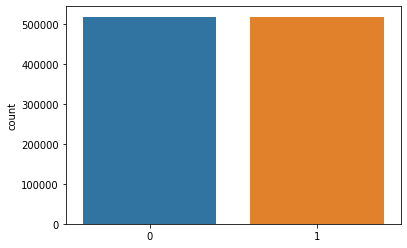

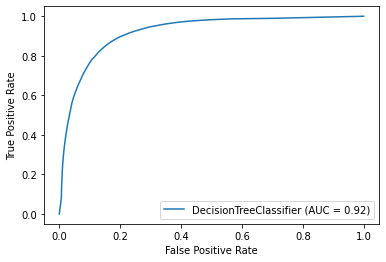

In [28]:
train_X, train_y=und_sampling(train_X, train_y)
clf, acc_decision_tree=decision_tree_classificador(train_X, test_X, train_y, test_y)
avalia_classificador(clf, test_X, test_y)
curva_roc(clf, test_X, test_y)

### Treinando o classificador 2: Random Forest

In [29]:
clf, acc_random_forest=random_forest_classificador(train_X, test_X, train_y, test_y)

### Avaliando o classificador 2

Relatório de precisão:
precision 			 recall 			 f-score 			 support
 [0.97471546 0.49999375] 	 [0.81324047 0.89850499] 	 [0.88668635 0.64247019] 	 [1070355  222474] 

Matriz de confusão:
 [[870456 199899]
 [ 22580 199894]] 

Accuracy score: 82.79130495989803 



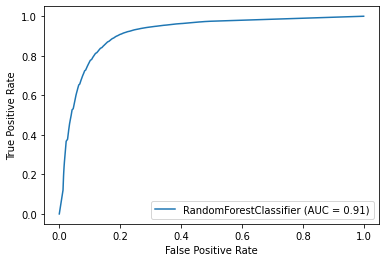

In [30]:
avalia_classificador(clf, test_X, test_y)
curva_roc(clf, test_X, test_y)

In [31]:
print('Acurácia com o classificador Random Forest', print('acc_random_forest', acc_random_forest))

acc_random_forest 82.79
Acurácia com o classificador Random Forest None
